# Analysis of chemo diversity on pharmacological and biological activities

The [dataset](results/activities_2022-01-29_16-33-05.csv) is obtained from the Scopus downloader version 2.0 from the [base set](data/activities.csv) of chemical compounds and activities.

**TODO** check:

- <https://stackoverflow.com/questions/53927460/select-rows-in-pandas-multiindex-dataframe>
- <https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#multiindex-query-syntax>


## Loading data obtained from Scopus

### Boilerplate

Some Python configuration.


In [88]:
from pathlib import Path
from itertools import islice, product
from pprint import pprint
import dataclasses

import pandas as pd
import numpy as np
import numpy.typing as npt
from scipy import linalg


import seaborn as sns
import matplotlib.pyplot as plt

# BUG sous linux avec Python 3.10
# import holoviews as hv
# We do it by ourselves
# import prince

import biblio_extractor as bex

np.set_printoptions(precision=4, suppress=True)
pd.set_option("display.float_format", lambda x: "{:.3f}".format(x))
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_rows", 20)
pd.set_option("display.min_rows", 10)

# (11.7, 8.27) = A4 landscape
sns.set(style="white", rc={"figure.figsize": (16.54, 11.7)})


DATASET_FILENAME = Path("results/activities_2022-01-29_16-33-05.csv")
print(f"{DATASET_FILENAME.stem = } {DATASET_FILENAME.suffix = }")


DATASET_FILENAME.stem = 'activities_2022-01-29_16-33-05' DATASET_FILENAME.suffix = '.csv'


### Loading the CSV file

Now, we load the dataset we'll use in this Notebook. It is generated using [our tool](biblio_extractor.py) in the same repository.
The dataset is a 106 \* 66 matrix, with rows and columns indexed by three levels (using Pandas's `MultiIndex`) as follows:

- level 0 is _class_ (chemical, biological or pharmacological class)
- level 1 is _name_ (compound or activity, a.k.a. keyword)
- level 2 is _kind_ (either _w/o_ for _without_ or _w/_ for _with_)

The matrix is indexed by _two_ disjoint finite sets of keywords:

- **rows**: a set of 53 (chemical) coumpounds = {acridine, triterpene, ...}
- **columns**: a set of 33 (biological, pharmacological) activities = {germination, cytotoxicity, ...}

An example is shown below, restricted to two compounds and two activities.
Note that this is **not** an extract of the whole dataset, the (w/o, w/o) cells being smaller here.

|                   |            |     | germination | germination | cytotoxicity | cytotoxicity |
| ----------------- | ---------- | --- | ----------- | ----------- | ------------ | ------------ |
|                   |            |     | allelopathy | allelopathy | pharmaco     | pharmaco     |
|                   |            |     | w/o         | w/          | w/o          | w/           |
| alkaloid          | acridine   | w/o | 2100        | 32          | 28           | 2104         |
| alkaloid          | acridine   | w/  | 1294        | 11          | 9            | 1296         |
| terpenoid/terpene | triterpene | w/o | 1283        | 11          | 9            | 1285         |
| terpenoid/terpene | triterpene | w/  | 2111        | 32          | 28           | 2115         |

Let $M$ be this matrix, and for each couple of keywords made of a compound and and activity, call $M_{ij} = (c_i, a_j)$, the **ij confusion submatrix**.
Assume that $M_ij$ is of the form :
\begin{bmatrix}
U & V\\
X & Y
\end{bmatrix}

Where :

- $U = (\text{w/o}, \text{w/o})$ is the number of papers that have **neither** the $c_i$ compound **nor** the $a_j$ activity;
- $V = (\text{w/o}, \text{w/})$ is the number of papers that have the $a_j$ activity but **not** the $c_i$ compound;
- $X = (\text{w/}, \text{w/o})$ is the number of papers that have the $c_i$ compound but **not** the $a_j$ activity;
- $Y = (\text{w/}, \text{w/})$ is the number of papers that have **both** the $c_i$ compound **and** the $a_j$ activity.

We avoid the open world hypothesis by restricting the analysis to the paper in the domain $D$,
which is the set of papers that have at least one compound and one activity.
By construction:

- $U + V$ and $X + Y$ are constants for each $c_i$ (whatever the choice of $a_j$) and is the total number of papers in $D$ with the $c_i$ comppound;
- $U + X$ and $V + Y$ are constants for each $a_j$ (whatever the choice of $c_i$) and is the total number of papers in $D$ with the $a_j$ activity.
- thus each confusion matrix $M_{ij}$ is such that $U + V + X + Y = |D|$ where $|D|$ is _the total number of paper_ under scrutiny.


In [2]:
dataset = pd.read_csv(DATASET_FILENAME, index_col=[0, 1, 2], header=[0, 1, 2])
# dataset.index.names = ["class", "name", "with"]
# dataset.columns.names = ["class", "name", "with"]

all_compounds = set(dataset.index.get_level_values(1))
all_activities = set(dataset.columns.get_level_values(1))

dataset

abiotic         \
                                                          antioxidant          
                                                                  w/o     w/   
alkaloid          acridine                            w/o      179092  62176   
                                                      w/         2430    266   
                  benzylamine                         w/o      180754  62371   
                                                      w/          768     71   
                  colchicine                          w/o      175968  62250   
...                                                               ...    ...   
terpenoid/terpene sesterterpene                       w/          182      7   
                  tetraterpene/carotenoid/xanthophyll w/o      178534  54855   
                                                      w/         2988   7587   
                  triterpene                          w/o      177099  61285   
                                                      w/         4423   1157   

                                                                         \
                                                          drought         
                                                              w/o    w/   
alkaloid          acridine                            w/o  240191  1077   
                                                      w/     2694     2   
                  benzylamine                         w/o  242046  1079   
                                                      w/      839     0   
                  colchicine                          w/o  237143  1075   
...                                                           ...   ...   
terpenoid/terpene sesterterpene                       w/      189     0   
                  tetraterpene/carotenoid/xanthophyll w/o  232655   734   
                                                      w/    10230   345   
                  triterpene                          w/o  237308  1076   
                                                      w/     5577     3   

                                                                   ...  \
                                                            metal  ...   
                                                              w/o  ...   
alkaloid          acridine                            w/o  216324  ...   
                                                      w/     2439  ...   
                  benzylamine                         w/o  218089  ...   
                                                      w/      674  ...   
                  colchicine                          w/o  213101  ...   
...                                                           ...  ...   
terpenoid/terpene sesterterpene                       w/      189  ...   
                  tetraterpene/carotenoid/xanthophyll w/o  208780  ...   
                                                      w/     9983  ...   
                  triterpene                          w/o  213234  ...   
                                                      w/     5529  ...   

                                                              pharmaco  \
                                                          cytotoxicity   
                                                                    w/   
alkaloid          acridine                            w/o        39229   
                                                      w/          1296   
                  benzylamine                         w/o        40400   
                                                      w/           125   
                  colchicine                          w/o        39268   
...                                                                ...   
terpenoid/terpene sesterterpene                       w/           113   
                  tetraterpene/carotenoid/xanthophyll w/o        40054   
                                       

### Extractiong the "old" "w/, w/" matrix

We can extract the "old" 53\*33 matrix we use in the version version of this software, where we had only the with/with queries.
In our small running example, that would be:

|                   |            | germination | cytotoxicity |
| ----------------- | ---------- | ----------- | ------------ |
|                   |            | allelopathy | pharmaco     |
| alkaloid          | acridine   | 11          | 1296         |
| terpenoid/terpene | triterpene | 32          | 2115         |


In [3]:
with_with_matrix = dataset.xs("w/", level=2).xs("w/", level=2, axis=1)
with_with_matrix

abiotic          \
                                                      antioxidant drought   
alkaloid          acridine                                    266       2   
                  benzylamine                                  71       0   
                  colchicine                                  192       4   
                  cyclopeptide                                 57       1   
                  imidazole                                  1082       8   
...                                                           ...     ...   
terpenoid/terpene polyterpene                                   0       0   
                  sesquiterpene                               863      17   
                  sesterterpene                                 7       0   
                  tetraterpene/carotenoid/xanthophyll        7587     345   
                  triterpene                                 1157       3   

                                                                        ...  \
                                                      metal   uv  salt  ...   
alkaloid          acridine                              257   80   163  ...   
                  benzylamine                           165   23    80  ...   
                  colchicine                             84   20   187  ...   
                  cyclopeptide                          168   16    35  ...   
                  imidazole                            2507  302  1195  ...   
...                                                     ...  ...   ...  ...   
terpenoid/terpene polyterpene                             0    0     0  ...   
                  sesquiterpene                          72   39    59  ...   
                  sesterterpene                           0    0     3  ...   
                  tetraterpene/carotenoid/xanthophyll   592  392   513  ...   
                  triterpene                             51   46    59  ...   

                                                      pharmaco             \
                                                         wound anticancer   
alkaloid          acridine                                  77        147   
                  benzylamine                               19         19   
                  colchicine                               222        171   
                  cyclopeptide                              51         45   
                  imidazole                                460        336   
...                                                        ...        ...   
terpenoid/terpene polyterpene                                0          0   
                  sesquiterpene                            124        114   
                  sesterterpene                              2          6   
                  tetraterpene/carotenoid/xanthophyll       97         51   
                  triterpene                               203        142   

                                                                             \
                                                      cytotoxicity sedative   
alkaloid          acridine                                    1296        8   
                  benzylamine                                  125        6   
                  colchicine                                  1257       34   
                  cyclopeptide                                 523        4   
                  imidazole                                   2816      486   
...                                                            ...      ...   
terpenoid/terpene polyterpene                                    0        0   
                  sesquiterpene                               2037       30   
                  sesterterpene                                113        1   
                  tetraterpene/carotenoid/xanthophyll          471        3   
                  triterpene                                  2109       22   

### Sanity checks

We do some sanity checks explained earlier :

- the name (level 2 of rows/columns) are _unique_
- the sum of each confusion submatrixes is _constant_ and is the total number of papers $|D|$, here 243 964.


In [4]:
# sanity check #1
assert dataset.shape == (2 * len(all_compounds), 2 * len(all_activities))
dataset


# sanity check : group by summing on level 2 on both rows and cols produce a matrix of constants : the number of papers
submatrix_sum = dataset.groupby(level=1).sum().groupby(level=1, axis=1).sum()
number_of_papers = np.unique(submatrix_sum.values)
# if the Scopus collection did not evolve during while querying
assert len(number_of_papers) == 1

number_of_papers = number_of_papers[0]
print(f"The domain contains {number_of_papers} papers")

with_with_total = with_with_matrix.values.sum()
print(
    f"Total number of positive/positive occurrences is {with_with_total} for {number_of_papers} papers (average={with_with_total/number_of_papers})"
)


The domain contains 243964 papers
Total number of positive/positive occurrences is 383330 for 243964 papers (average=1.571256414880884)


## Analysing data

### Extracting the confusion submatrixes

Lets illustrate the content of this table. The **2 by 2 confusion submatrix** about _acridine_ and _cytotoxicity_ is as follows.


In [5]:
acridine_cytotoxicity_submatrix = dataset.loc[
    (
        "alkaloid",
        "acridine",
    ),
    (
        "pharmaco",
        "cytotoxicity",
    ),
]
print(f"Among {number_of_papers} papers, there are")
for i, j in product(bex.SELECTORS, bex.SELECTORS):
    print(f"{acridine_cytotoxicity_submatrix.loc[i,j]} papers {i} acridine and {j} cytotoxicity in their keywords")

print("The acridine and cytotoxicity confusion matrix is as follows")
acridine_cytotoxicity_submatrix


Among 243964 papers, there are
202039 papers w/o acridine and w/o cytotoxicity in their keywords
39229 papers w/o acridine and w/ cytotoxicity in their keywords
1400 papers w/ acridine and w/o cytotoxicity in their keywords
1296 papers w/ acridine and w/ cytotoxicity in their keywords
The acridine and cytotoxicity confusion matrix is as follows


C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


,w/o,w/
w/o,202039,39229
w/,1400,1296


### Marginal sums

We compute marginal sums on rows and cols and add them to the orginial dataset.

**NOTE** we actually should do the other way around, that is to query Scopue for margin and for all (w/, w/) cells and _then_ fill in the missing ones.

In [6]:
margin_idx = (bex.CLASS_SYMB, bex.MARGIN_SYMB, bex.SELECTORS[1])
margin_cols = dataset.groupby(level=1).sum().drop_duplicates().reset_index(drop=True)
margin_cols.index = pd.MultiIndex.from_tuples([margin_idx])

margin_rows = dataset.groupby(level=1, axis=1).sum().iloc[:, 0]
margin_rows.name = margin_idx
margin_rows = pd.DataFrame(margin_rows)

dataset_margins = dataset.copy()
dataset_margins[margin_idx] = margin_rows
dataset_margins = pd.concat([dataset_margins, margin_cols]).fillna(number_of_papers).astype(int)

dataset_margins


*     abiotic  \
                                                                Σ antioxidant   
                                                               w/          w/   
alkaloid          acridine                            w/o  241268       62176   
                                                      w/     2696         266   
                  benzylamine                         w/o  243125       62371   
                                                      w/      839          71   
                  colchicine                          w/o  238218       62250   
...                                                           ...         ...   
terpenoid/terpene tetraterpene/carotenoid/xanthophyll w/o  233389       54855   
                                                      w/    10575        7587   
                  triterpene                          w/o  238384       61285   
                                                      w/     5580        1157   
*                 Σ                                   w/   243964       62442   

                                                                           \
                                                                  drought   
                                                              w/o      w/   
alkaloid          acridine                            w/o  179092    1077   
                                                      w/     2430       2   
                  benzylamine                         w/o  180754    1079   
                                                      w/      768       0   
                  colchicine                          w/o  175968    1075   
...                                                           ...     ...   
terpenoid/terpene tetraterpene/carotenoid/xanthophyll w/o  178534     734   
                                                      w/     2988     345   
                  triterpene                          w/o  177099    1076   
                                                      w/     4423       3   
*                 Σ                                   w/   181522    1079   

                                                                   ...  \
                                                                   ...   
                                                              w/o  ...   
alkaloid          acridine                            w/o  240191  ...   
                                                      w/     2694  ...   
                  benzylamine                         w/o  242046  ...   
                                                      w/      839  ...   
                  colchicine                          w/o  237143  ...   
...                                                           ...  ...   
terpenoid/terpene tetraterpene/carotenoid/xanthophyll w/o  232655  ...   
                                                      w/    10230  ...   
                  triterpene                          w/o  237308  ...   
                                                      w/     5577  ...   
*                 Σ                                   w/   242885  ...   

                                                          pharmaco        \
                                                          sedative wound   
                                                               w/o    w/   
alkaloid          acridine                            w/o   238785  6707   
                                                      w/      2688    77   
                  benzylamine                         w/o   240640  6765   
                                                      w/       833    19   
                  colchicine                          w/o   235761  6562   
...                                                            ...   ...   
terpenoid/terpene tetraterpene/carotenoid/xanthophyll w/o   230901  6687   
                                                     

### Aggregating submatrixes to a scalar

The <https://en.wikipedia.org/wiki/Confusion_matrix> can be equipped with _a lot_ of different metrics (or score) that aggregate the $2 \times 2$ matrix to a single scalar value.
One of the best is the <https://en.wikipedia.org/wiki/Phi_coefficient>

However, we are not exactly in the context of a confusion table. Moreover we do not have argument to provilege one metric over another. So we explore a part of the space.

#### Some metrics

We may analyze the "influence" of each margin to the score to design our own

In [7]:
def intersection_metric(arr):
    """The trivial one. Just keep the bottom right cell. Amount to compute on "the old matrix" """
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return TT / (FF + FT + TF + TT)


def row_implication_metric(arr):
    """The % of paper that have both keywords among the first one. Values add to 1 row wise"""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return TT / (TF + TT)


def col_implication_metric(arr):
    """The % of paper that have both keywords among the second one. Values add to 1 col wise"""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return TT / (FT + TT)


def fowlkes_mallows_metric(arr):
    """Computes the Fowlkes-Mallows index: sqrt(the product of row and col implication)"""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return TT / np.sqrt((FT + TT) * (TF + TT))


def accuracy_metric(arr):
    """Computes the accuracy"""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return (TT + FF) / (FF + FT + TF + TT)


def x_metric(arr):
    """Some another one by our own"""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return (FF + TT - FT - TF) / (FF + FT + TF + TT)


def fraction_metric(arr):
    """The % of paper that have both keywords among the ones having at least one."""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return TT / (FT + TF - TT)


metrics = [
    intersection_metric,
    row_implication_metric,
    col_implication_metric,
    fowlkes_mallows_metric,
    accuracy_metric,
    x_metric,
    fraction_metric,
]


print("An example on the acridine/cytotoxicity submatrix, its score for each metric")
print(acridine_cytotoxicity_submatrix)

for metric in metrics:
    print(f"{metric.__name__:<22} = {metric(acridine_cytotoxicity_submatrix.values)}")


An example on the acridine/cytotoxicity submatrix, its score for each metric
        w/o     w/
w/o  202039  39229
w/     1400   1296
intersection_metric    = 0.005312259185781509
row_implication_metric = 0.4807121661721068
col_implication_metric = 0.03198025909932141
fowlkes_mallows_metric = 0.12398911091858036
accuracy_metric        = 0.8334631339050024
x_metric               = 0.6669262678100047
fraction_metric        = 0.03294943177484555


**Remark** we'd love to say that "acridine  _partly implies_ cytotoxicity " ! Among 33 activities, about 48% of papers about acridine are about cytotoxicity !
**Important** look for implication rules ?

### Applying the metrics

First, we have some fun with Numpy

In [8]:
# redimension the values to a 4D array
C, A = len(all_compounds), len(all_activities)
print(C, A)
M_2_2 = np.moveaxis(dataset.values.reshape((C, 2, A, 2)), 1, -2)
# 1D is easier for apply_along_axis
M_4 = M_2_2.reshape((C * A, 4))

print(f"{M_2_2.shape = }")
print(f"{M_4.shape = }")

# M.sum(axis=(2,3)) or similarly
np_nb_paper = np.sum(M_2_2, axis=(2, 3), keepdims=False)
print(f"{np.all(np_nb_paper == number_of_papers) = } (with {number_of_papers = })")



53 33
M_2_2.shape = (53, 33, 2, 2)
M_4.shape = (1749, 4)
np.all(np_nb_paper == number_of_papers) = True (with number_of_papers = 243964)


We obtain the same as submatrix_sum


In [24]:
score_df = {}
for metric in metrics:
    metric_name = metric.__name__
    matrix = np.apply_along_axis(metric, 1, M_4).reshape((C, A))

    score_df[metric_name] = pd.DataFrame(matrix, index=with_with_matrix.index, columns=with_with_matrix.columns)
    # print(score_df)
    filename = Path(f"{DATASET_FILENAME.stem}_{metric_name}{DATASET_FILENAME.suffix}")
    score_df[metric_name].to_csv(Path("results") / filename)


scores_summary_df = pd.DataFrame.from_dict(
    {f_name: [df.values.min(), df.values.mean(), df.values.max(), df.values.std()] for f_name, df in score_df.items()},
    orient="index",
    columns=["min", "mean", "max", "std"],
)


scores_summary_df


,min,mean,max,std
intersection_metric,0.000,0.001,0.114,0.004
row_implication_metric,0.000,0.038,1.000,0.081
col_implication_metric,0.000,0.022,0.583,0.050
fowlkes_mallows_metric,0.000,0.018,0.504,0.035
accuracy_metric,0.655,0.941,1.000,0.064
x_metric,0.310,0.881,1.000,0.129
fraction_metric,0.000,0.008,0.957,0.036


### Correspondance Analysis

Here, we implement Correspondance Analysis from scratch using SVD from from `scipy.linalg`.
We explore the results on all previous metrics.

In [25]:
# sanity checks
def sanity_scores(all_dfs):
    for metric_name, df in all_dfs.items():
        # The input matrix: the dataset after a metric is applied
        M = df.values
        N = np.sum(M)
        # Z is M normalised
        Z = M / N
        print(f"{metric_name} (grand total {N = })")

        R = np.sum(M, axis=1)  # X @ np.ones(X.shape[1])
        C = np.sum(M, axis=0)  # Z @ np.ones(X.shape[0])

        print(f"    {np.sum(R) = :.4f} and {np.sum(C) = :.4f}")

        r = np.sum(Z, axis=1)
        c = np.sum(Z, axis=0)
        # print(f"    {r[:, np.newaxis].shape = } {c[:, np.newaxis].shape = }")
        print(
            f"    {np.sum(r) = :.4f} and {np.sum(c) = :.4f}"
        )  # \n{100*r = } \n{100*c = }


sanity_scores(score_df)


intersection_metric (grand total N = 1.571256414880884)
    np.sum(R) = 1.5713 and np.sum(C) = 1.5713
    np.sum(r) = 1.0000 and np.sum(c) = 1.0000
row_implication_metric (grand total N = 65.7895272917367)
    np.sum(R) = 65.7895 and np.sum(C) = 65.7895
    np.sum(r) = 1.0000 and np.sum(c) = 1.0000
col_implication_metric (grand total N = 38.76436344379413)
    np.sum(R) = 38.7644 and np.sum(C) = 38.7644
    np.sum(r) = 1.0000 and np.sum(c) = 1.0000
fowlkes_mallows_metric (grand total N = 31.23157570524735)
    np.sum(R) = 31.2316 and np.sum(C) = 31.2316
    np.sum(r) = 1.0000 and np.sum(c) = 1.0000
accuracy_metric (grand total N = 1645.1038062992902)
    np.sum(R) = 1645.1038 and np.sum(C) = 1645.1038
    np.sum(r) = 1.0000 and np.sum(c) = 1.0000
x_metric (grand total N = 1541.2076125985802)
    np.sum(R) = 1541.2076 and np.sum(C) = 1541.2076
    np.sum(r) = 1.0000 and np.sum(c) = 1.0000
fraction_metric (grand total N = 14.778185526117818)
    np.sum(R) = 14.7782 and np.sum(C) = 14.778

In [34]:
def normalize(df, *, method="laplace"):
    M = df.values
    # normalize by grand total
    Z = M / np.sum(M)
    # margins
    r = np.sum(Z, axis=1)
    c = np.sum(Z, axis=0)
    # Dc = np.diag(c)
    # Dr = np.diag(r)
    # center Z
    Zc = Z - (r[:, np.newaxis] @ (c[:, np.newaxis].T))
    # normalize
    if method == "laplace":
        S = np.diag(r ** (-0.5)) @ Zc @ np.diag(c ** (-0.5))
    elif method == "rows":
        S = np.diag(r ** (-1)) @ Zc
    elif method == "cols":
        S = Zc @ np.diag(c ** (-1))
    else:
        raise ValueError(f"unknown normalization {method = }")

    return S, r, c


for metric_name, matrix in score_df.items():
    S, r, c = normalize(matrix, method="laplace")
    print(f"{metric_name} {S.shape}, margins:")
    # print(S)
    print(f"rows sum is {np.sum(S, axis=1).sum()}\n{np.sum(S, axis=1)}")
    print(f" cols sum is {np.sum(S, axis=0).sum()}\n{np.sum(S, axis=0)}")


intersection_metric (53, 33), margins:
rows sum is 0.9753857591248029
[-0.0141  0.0227  0.1352  0.0869  0.1013  0.0759  0.0174  0.0249  0.0879
  0.0123  0.0221  0.0139  0.1372  0.0719  0.0801  0.1284  0.0072  0.0378
  0.0289  0.0399  0.0109  0.0495  0.0251  0.0725  0.0342  0.004  -0.0041
 -0.0395 -0.2416 -0.0013 -0.026  -0.0136 -0.2169 -0.0639  0.0378 -0.0699
 -0.0834 -0.0359 -0.0182 -0.0076  0.0642  0.0276  0.0121  0.1107  0.008
  0.0505  0.0995  0.0232 -0.0022  0.0955 -0.01   -0.0398  0.0061]
 cols sum is 0.9753857591248027
[-0.5901  0.1177 -0.1521 -0.1046  0.0796  0.0528  0.0124  0.0946  0.0299
  0.0409  0.0355  0.0132  0.0462  0.0098 -0.0081  0.0172 -0.0529  0.1168
  0.0406  0.0074 -0.0242  0.1552 -0.0848  0.0699  0.1968  0.1045  0.1936
 -0.0301 -0.0179  0.0691  0.4415 -0.0063  0.1012]
row_implication_metric (53, 33), margins:
rows sum is 0.015783114449158076
[-0.0639  0.0319  0.0919  0.0936  0.0357  0.0153  0.0673 -0.0074  0.0803
  0.0665  0.003   0.0803  0.1136  0.0294  0.1014  0

In [77]:
# the number of dimensions we project onto
NAXIS = 2
NEXAMPLES = 10

# TODO use the standard scipy API
@dataclasses.dataclass
class CA:
    rows_coordinates: npt.NDArray
    cols_coordinates: npt.NDArray
    inertias: npt.NDArray
    


def correspondence_analysis(df) -> CA:

    # normalize
    S, r, c = normalize(df, method="laplace")
    # decompose
    U, D, Vt = linalg.svd(S)
    # diagonal of sqrt of "eigenvalues"
    Da = np.eye(U.shape[0], Vt.shape[0]) * D

    # print(f"{ U.shape,  D.shape, Da.shape, Vt.shape = }")

    # SVD ensures that Vt  @ Vt.T == I == U.T @ U
    assert np.allclose(Vt @ Vt.T, np.identity(Vt.shape[0]))
    assert np.allclose(U.T @ U, np.identity(U.shape[0]))

    # BUG/TODO : this depends on the normalization method !
    r_std_coords = np.diag(r ** (-0.5)) @ U
    r_coords = r_std_coords @ Da
    # print(f"{r_coords.shape}, first {NEXAMPLES} : {r_coords[:NEXAMPLES, NAXIS]}")

    c_std_coords = np.diag(c ** (-0.5)) @ Vt.T
    c_coords = c_std_coords @ Da.T
    # print(f"{c_coords.shape}, first {NEXAMPLES} : {c_coords[:NEXAMPLES, NAXIS]}")

    # smallest dimension
    K = min(S.shape)
    principal_inertias = np.diag(Da) ** 2
    # print(f"(eigenvalues) {principal_inertias = }")

    total_inertia = np.trace(S @ S.T)
    # print(f"{total_inertia = }")

    explained_inertias = 100 * principal_inertias / total_inertia
    # print(f"(in %) {explained_inertias = }")

    return CA(r_coords, c_coords, principal_inertias)

for m_name, df in score_df.items():
    res = correspondence_analysis(df)
    print(m_name)
    print(f"    total inertia {res.inertias.sum()} ({res.inertias.shape})")
    print(f"    explained inertias on first {NAXIS} axis (%) = {100*res.inertias[:NAXIS].sum()/res.inertias.sum():.4f} {100*res.inertias[:NAXIS]/res.inertias.sum()}")

intersection_metric
    total inertia 0.6768601446110587 ((33,))
    explained inertias on first 2 axis (%) = 52.5342 [34.2743 18.2599]
row_implication_metric
    total inertia 1.213574590857687 ((33,))
    explained inertias on first 2 axis (%) = 34.8698 [17.9887 16.8811]
col_implication_metric
    total inertia 1.5098879411451203 ((33,))
    explained inertias on first 2 axis (%) = 34.2811 [19.7614 14.5197]
fowlkes_mallows_metric
    total inertia 1.1359045817440268 ((33,))
    explained inertias on first 2 axis (%) = 30.0285 [18.8789 11.1496]
accuracy_metric
    total inertia 6.511587717542786e-05 ((33,))
    explained inertias on first 2 axis (%) = 92.8254 [88.556   4.2694]
x_metric
    total inertia 0.00033198873185645475 ((33,))
    explained inertias on first 2 axis (%) = 94.2340 [90.0678  4.1661]
fraction_metric
    total inertia 2.091744214063845 ((33,))
    explained inertias on first 2 axis (%) = 34.8782 [19.75   15.1283]


### Graphical representation of compounds on the first two axis

Now, we draw compounds and activities as scatterplots on the first 2 dimensions.

In [101]:
def data_to_ca(df, r_coords, c_coords):
    # r_coords, c_coords, inertias = dataclasses.astuple(correspondence_analysis(df))


    compounds_ca = pd.DataFrame(index=df.index.droplevel())
    compounds_ca["1st axis"] = r_coords[:, 0]
    compounds_ca["2nd axis"] = -r_coords[:, 1]
    compounds_ca["class"] = df.index.droplevel(1)
    compounds_ca["total"] = np.sum(df.values, axis=1)
    compounds_ca["type"] = "Compound"



    activities_ca = pd.DataFrame(index=df.columns.droplevel())
    activities_ca["1st axis"] = c_coords[:, 0]
    activities_ca["2nd axis"] = -c_coords[:, 1]
    activities_ca["class"] = df.columns.droplevel(1)
    activities_ca["total"] = np.sum(df.values, axis=0)
    activities_ca["type"] = "Activity"

    full_ca = pd.concat([compounds_ca, activities_ca], axis= 0)
    return full_ca

df = score_df["intersection_metric"]
ca_res = correspondence_analysis(df)
plot_ca = data_to_ca(df, ca_res.rows_coordinates, ca_res.cols_coordinates)
plot_ca

,1st axis,2nd axis,class,total,type
acridine,-0.314,0.393,alkaloid,0.014,Compound
benzylamine,-0.315,0.372,alkaloid,0.004,Compound
colchicine,-0.736,0.456,alkaloid,0.028,Compound
cyclopeptide,-0.804,-0.102,alkaloid,0.013,Compound
imidazole,-0.446,0.284,alkaloid,0.080,Compound
...,...,...,...,...,...
wound,-0.393,-0.570,pharmaco,0.033,Activity
anticancer,-0.263,0.323,pharmaco,0.023,Activity
cytotoxicity,-0.262,0.303,pharmaco,0.201,Activity
sedative,-0.705,0.534,pharmaco,0.011,Activity


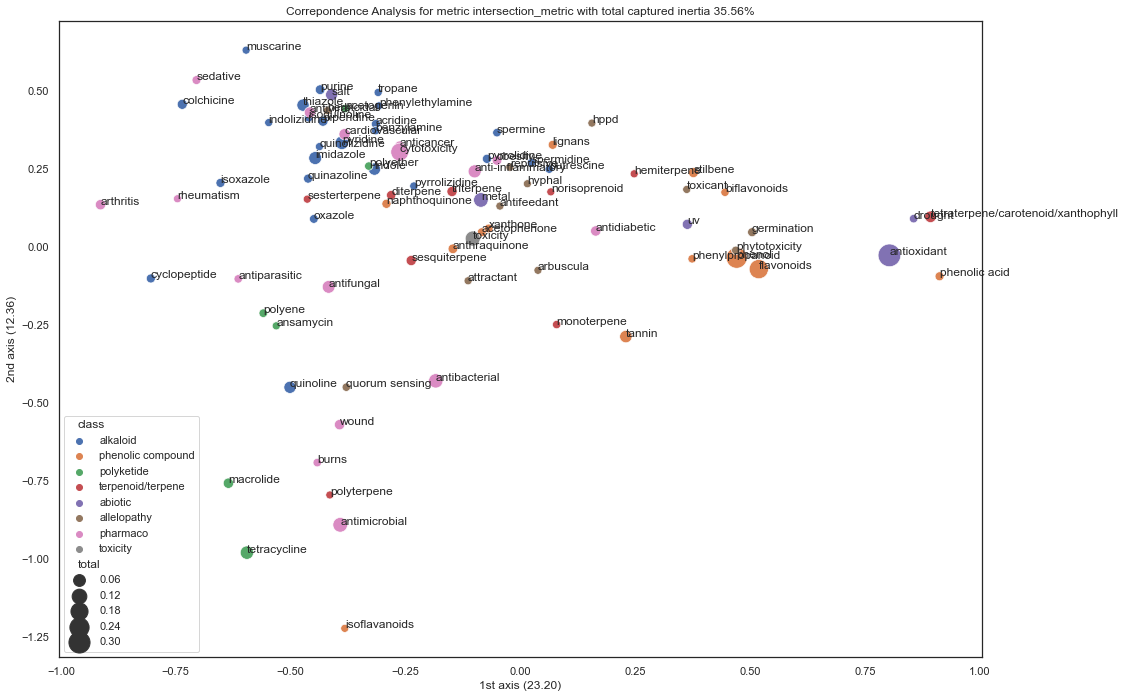

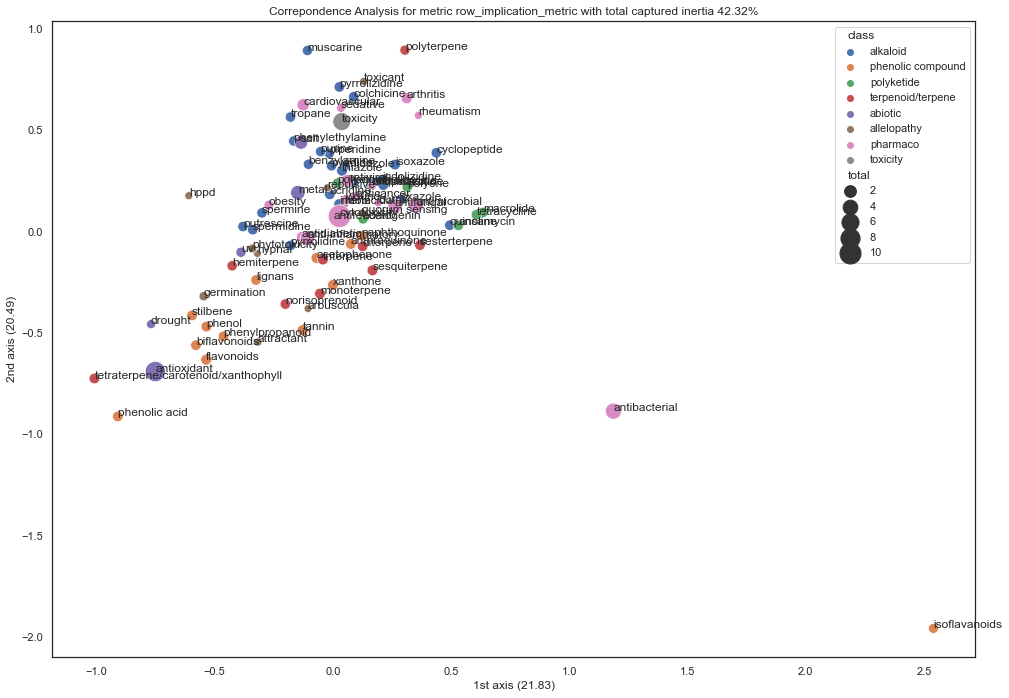

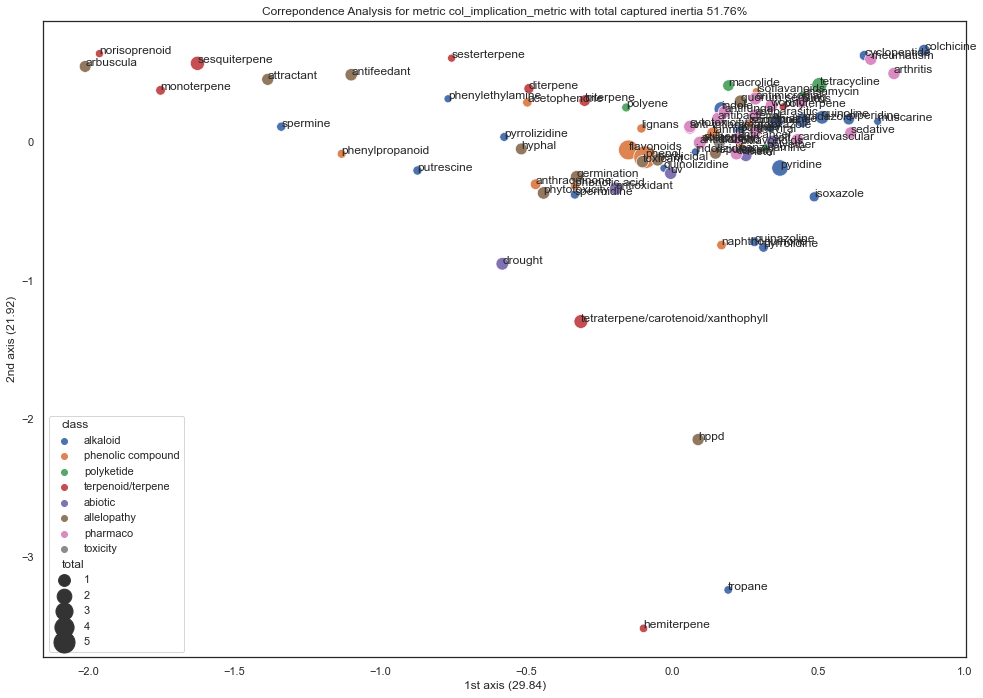

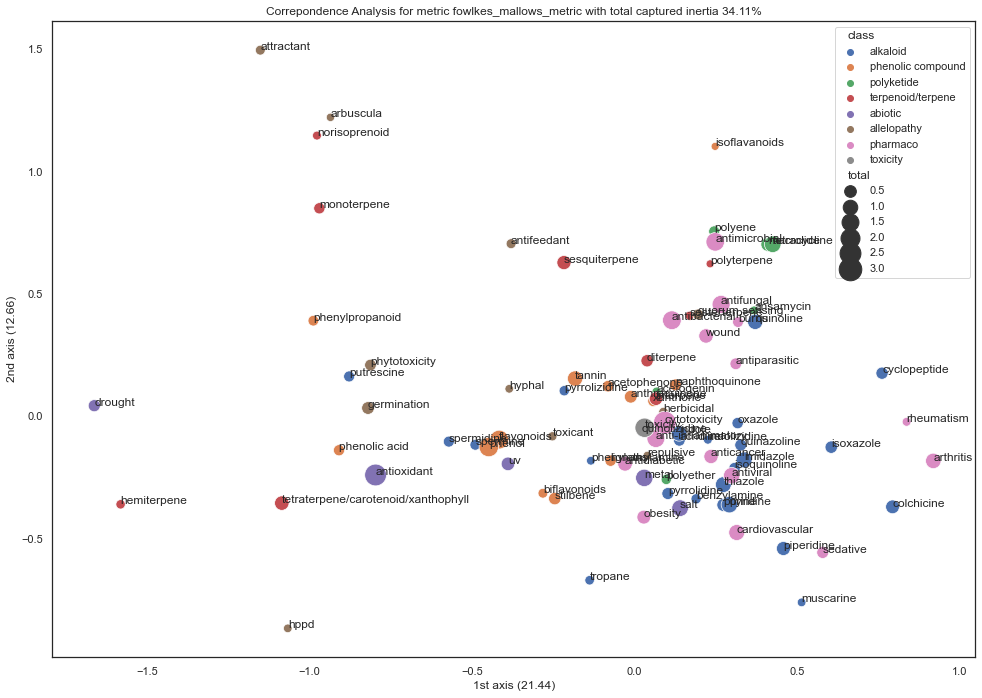

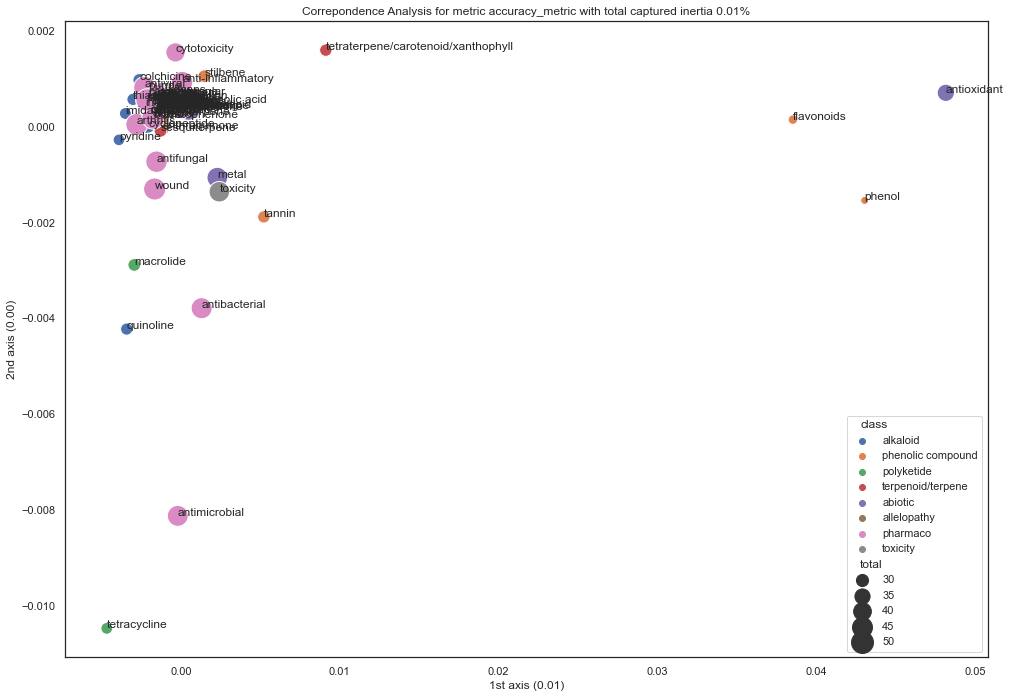

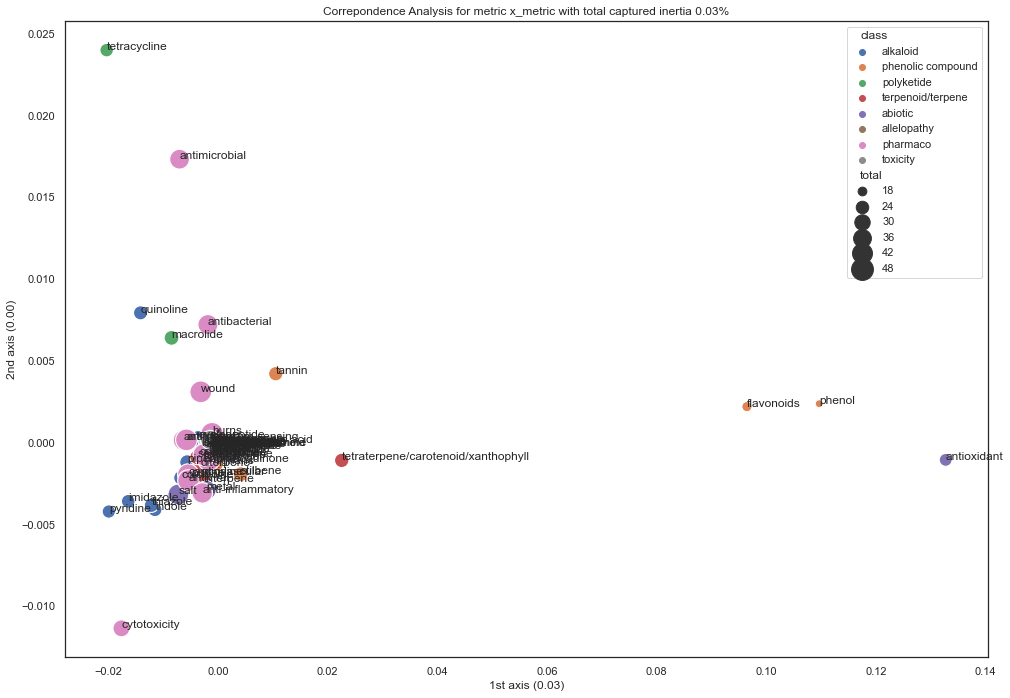

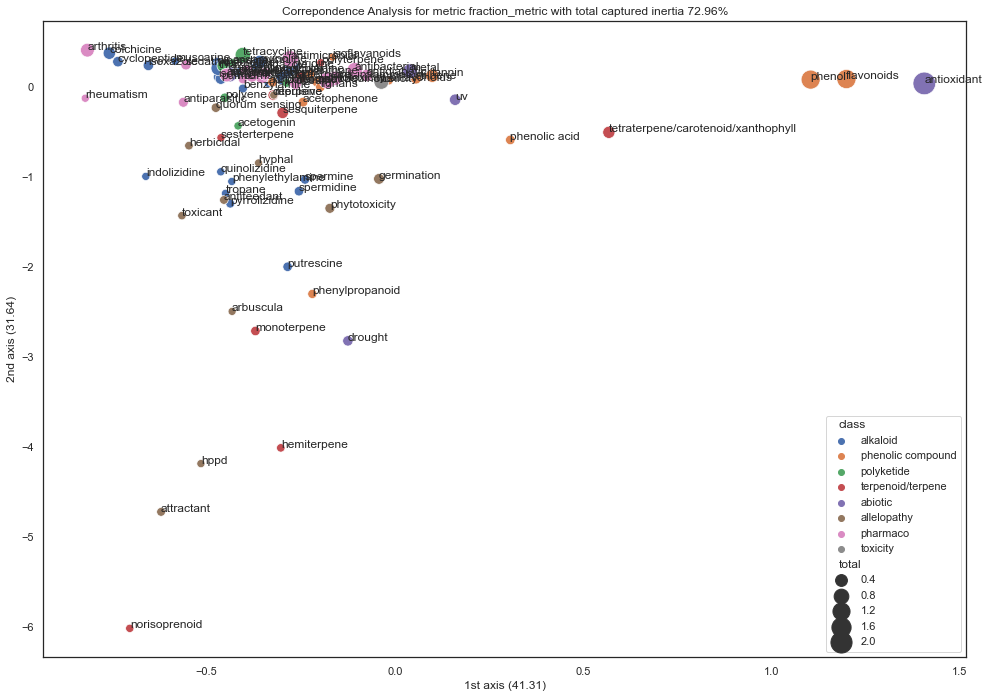

In [112]:
SHIFT = 0.00

for f_name, df in score_df.items():
    ca_res = correspondence_analysis(df)
    plot_ca = data_to_ca(df, ca_res.rows_coordinates, ca_res.cols_coordinates)

    ax = sns.scatterplot(data=plot_ca, x="1st axis", y="2nd axis", hue="class", size="total", sizes=(64, 512))
    ax.set_title(f"Correpondence Analysis for metric {f_name} with total captured inertia {100*ca_res.inertias[:2].sum():.2f}%")
    ax.set_xlabel(f"1st axis ({100*ca_res.inertias[0]:.2f})")
    ax.set_ylabel(f"2nd axis ({100*ca_res.inertias[1]:.2f})")
    for index, row in plot_ca.iterrows():
        ax.annotate(index, (row["1st axis"] + SHIFT, row["2nd axis"] + SHIFT))
    plt.show()


In [ ]:
print("Best implication rules")